In [32]:
!date

Wed Feb 16 17:04:27 PST 2022


# Cluster-wise comparison between control and experiment datasets
Clustering performed on pooled data.
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [33]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [34]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom violinplot code
from plotting_funcs import violinplot

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [35]:
# set random seed
np.random.seed(926)

In [36]:
def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load AnnData object

In [37]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [38]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [39]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

adata.obs

species        batch  n_counts_processed batch_index  \
barcode                                                                       
AAACCCAAGCACTGGA-0  zebrafinch     control1          483.000000           0   
AAACCCAAGCGTCAAG-0  zebrafinch     control1          946.000061           0   
AAACCCAAGGTCACAG-0  zebrafinch     control1         1068.000000           0   
AAACCCAAGTCATTGC-0  zebrafinch     control1         1407.000000           0   
AAACCCAAGTGCTACT-0  zebrafinch     control1         1060.000000           0   
...                        ...          ...                 ...         ...   
TTTGTTGTCAACTCTT-3  zebrafinch  experiment2          791.999939           3   
TTTGTTGTCGATCCAA-3  zebrafinch  experiment2         4345.000000           3   
TTTGTTGTCTAGATCG-3  zebrafinch  experiment2         1352.000000           3   
TTTGTTGTCTGTCTCG-3  zebrafinch  experiment2         1289.000000           3   
TTTGTTGTCTGTGCTC-3  zebrafinch  experiment2          790.000000           3   

                    n_counts_raw leiden                              celltype  \
barcode                                                                         
AAACCCAAGCACTGGA-0    483.000000     13                         mural cells 2   
AAACCCAAGCGTCAAG-0    946.000061      3                           microglia 1   
AAACCCAAGGTCACAG-0   1068.000000      1                   GABAergic neurons 1   
AAACCCAAGTCATTGC-0   1407.000000     10                          astrocytes 2   
AAACCCAAGTGCTACT-0   1060.000000      1                   GABAergic neurons 1   
...                          ...    ...                                   ...   
TTTGTTGTCAACTCTT-3    791.999939      0               glutamatergic neurons 1   
TTTGTTGTCGATCCAA-3   4345.000000      2                 migrating neuroblasts   
TTTGTTGTCTAGATCG-3   1352.000000      6  mural / vascular endothelial cells 1   
TTTGTTGTCTGTCTCG-3   1289.000000     12                   GABAergic neurons 2   
TTTGTTGTCTGTGCTC-3    790.000000      0               glutamatergic neurons 1   

                   connectivity     batch_g  
barcode                                      
AAACCCAAGCACTGGA-0            0     control  
AAACCCAAGCGTCAAG-0            1     control  
AAACCCAAGGTCACAG-0            2     control  
AAACCCAAGTCATTGC-0            3     control  
AAACCCAAGTGCTACT-0            2     control  
...                         ...         ...  
TTTGTTGTCAACTCTT-3  undefined 1  experiment  
TTTGTTGTCGATCCAA-3            9  experiment  
TTTGTTGTCTAGATCG-3            6  experiment  
TTTGTTGTCTGTCTCG-3           10  experiment  
TTTGTTGTCTGTGCTC-3  undefined 1  experiment  

[35804 rows x 9 columns]

___

# Find DE genes filtered based on fold change and expression inside/outside group

Set filters:  
min_fold_change = Minimum fold change between mean gene expression between control and experiment.  
min_in_group_fraction = Minimum percentage of cells inside the cluster of interest that express the gene.  
max_out_group_fraction = Maximum percentage of cells outside the cluster of interest that express the gene.

In [40]:
min_fold_change = 1.5
min_in_group_fraction = 0.25   
max_out_group_fraction = 1  

In [41]:
# Display all clusters
np.sort(adata.obs.celltype.values.unique())

array(['GABAergic neurons 1', 'GABAergic neurons 2',
       'GABAergic neurons 3', 'astrocytes 1', 'astrocytes 2',
       'glutamatergic neurons 1', 'glutamatergic neurons 2',
       'glutamatergic neurons 3', 'glutamatergic neurons 4',
       'microglia 1', 'microglia 2', 'microglia 3 / radial glia',
       'migrating neuroblasts', 'mural / vascular endothelial cells 1',
       'mural cells 2', 'oligodendrocyte precursor cells',
       'oligodendrocytes 1', 'oligodendrocytes 2', 'oligodendrocytes 3',
       'radial glia 1', 'radial glia 2', 'red blood cells'], dtype=object)

In [42]:
# Empty arrays to store DE genes
DE_ctrl = []
DE_exp = []

# Define clusters to be searched for DE genes
clusters = [
    "GABAergic neurons 1",
    "GABAergic neurons 2",
    "astrocytes 1",
    "astrocytes 2",
    "glutamatergic neurons 1",
    "glutamatergic neurons 2",
    "glutamatergic neurons 3",
    "glutamatergic neurons 4",
    "microglia 1",
    "microglia 2",
]

for cluster in clusters:
    adata_temp = adata[
        np.char.startswith(nd(adata.obs.celltype.values).astype(str), cluster)
    ]

    # Find DE genes comparing experiment and control for this one cluster
    sc.tl.rank_genes_groups(adata_temp, 
                            groupby="batch_g", 
                            use_raw=False,
                            method="t-test"
                           )

    # Apply filters
    sc.tl.filter_rank_genes_groups(
        adata_temp,
        use_raw=False,
        min_fold_change=min_fold_change,
        min_in_group_fraction=min_in_group_fraction,
        max_out_group_fraction=max_out_group_fraction,
    )
    # Get all DE genes that fit filter
    DE_genes = pd.DataFrame(adata_temp.uns["rank_genes_groups_filtered"]["names"])
    DE_genes_ctrl = DE_genes["control"].values
    DE_genes_exp = DE_genes["experiment"].values

    # Filter out NaN values (if less than 20 genes were found)
    DE_genes_ctrl = DE_genes_ctrl[~pd.isna(DE_genes_ctrl)]
    DE_genes_exp = DE_genes_exp[~pd.isna(DE_genes_exp)]

    # Store in arrays
    DE_ctrl.append(DE_genes_ctrl)
    DE_exp.append(DE_genes_exp)

# Concatenate arrays into one array
DE_ctrl = np.concatenate(DE_ctrl)
DE_exp = np.concatenate(DE_exp)

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: Implic

In [43]:
# Keep each gene only once without alphabetic sorting
indeces = np.unique(DE_ctrl, return_index=True)[1]
DE_ctrl = [DE_ctrl[index] for index in sorted(indeces)]

indeces_exp = np.unique(DE_exp, return_index=True)[1]
DE_exp = [DE_exp[index] for index in sorted(indeces_exp)]

In [44]:
ctrl_gene_names = [
    "Voltage-Gated Potassium Channel Subunit Beta-3-like",
    "Ribosomal Protein L17 (RPL17)",
    "Proteasome 20S Subunit Beta 5-like\n(PSMB5) (isoform 1?)",
    "Thyroid Stimulating Hormone Receptor (TSHR)",
    "Solute Carrier Family 3 Member 2-like (SLC3A2)",
    "WRE (transgene sequence)",
    "Insulin Like Growth Factor 2 (IGF2)",
    "Urotensin 2B (UTS2B)",
    "Proenkephalin (PENK)",
    "ENSTGUG00000019157 (novel protein-coding)",
    "Yippee Like 4 (YPEL4)",
    "Tubulin beta-7 chain",
    "All-Trans Retinoic Acid Induced\nDifferentiation factor (ATRAID)",
    "CAMP Responsive Element Modulator (CREM)",
    "Optic atrophy 3 (OPA3) protein homolog",    
    "Adenylosuccinate Synthase 1 (ADSS 1)",
    "Actin, cytoplasmic type 5",
    "G Protein-Coupled Receptor Kinase 5 (GRK5)",
    "Single-Strand-Selective Monofunctional\n Uracil-DNA Glycosylase 1-like (SMUG1)",
    "GDNF Family Receptor Alpha 1 (GFRA1)",
    "ENSTGUG00000029247 (novel protein coding)",
    "PH Domain Containing Endocytic\nTrafficking Adaptor 2 (PHETA2)",
    "Pleckstrin Homology Domain Containing A3 (PLEKHA3)",
    "Dual Specificity Phosphatase 23 (DUSP23)",
    "Calponin 3 (CNN3)",
    "ENSTGUG00000025966\nSplicing factor, proline- and glutamine-rich-like",
    "Plexin Domain Containing 1 (PLXDC1)",
    "Cytochrome P450 Family 4 Subfamily V Member 2 (CYP4V2)",
    "ENSTGUG00000020132 (lncRNA)",
    "ENSTGUG00000024659 (lncRNA)",
    "ENSTGUG00000025857 (lncRNA)"
]

df_DE_ctrl = pd.DataFrame()
df_DE_ctrl["gene_ID"] = DE_ctrl
df_DE_ctrl["gene_name"] = ctrl_gene_names
# Sort genes alphabetically 
df_DE_ctrl = df_DE_ctrl.sort_values("gene_name")
df_DE_ctrl.to_csv("CTRL_DE-genes_ind-clusters_t-test.csv")
df_DE_ctrl

gene_ID  \
16         _ENSTGUG00000004026.2   
15    ADSS1_ENSTGUG00000012901.2   
12         _ENSTGUG00000029336.1   
13         _ENSTGUG00000025735.1   
24     CNN3_ENSTGUG00000005620.2   
27   CYP4V2_ENSTGUG00000006924.2   
23   DUSP23_ENSTGUG00000016440.2   
9          _ENSTGUG00000019157.1   
28         _ENSTGUG00000020132.1   
29         _ENSTGUG00000024659.1   
30         _ENSTGUG00000025857.1   
25         _ENSTGUG00000025966.1   
20         _ENSTGUG00000029247.1   
17     GRK5_ENSTGUG00000011126.2   
19    GFRA1_ENSTGUG00000018882.1   
6      IGF2_ENSTGUG00000009330.2   
14         _ENSTGUG00000029604.1   
21   PHETA2_ENSTGUG00000029353.1   
22  PLEKHA3_ENSTGUG00000009194.2   
26   PLXDC1_ENSTGUG00000028549.1   
8      PENK_ENSTGUG00000011112.2   
2          _ENSTGUG00000027088.1   
1     RPL17_ENSTGUG00000028072.1   
18         _ENSTGUG00000028939.1   
4          _ENSTGUG00000027801.1   
3      TSHR_ENSTGUG00000012373.2   
11         _ENSTGUG00000029087.1   
7     UTS2B_ENSTGUG00000009278.2   
0          _ENSTGUG00000027913.1   
5                        WRE_WRE   
10    YPEL4_ENSTGUG00000023978.1   

                                            gene_name  
16                          Actin, cytoplasmic type 5  
15               Adenylosuccinate Synthase 1 (ADSS 1)  
12  All-Trans Retinoic Acid Induced\nDifferentiati...  
13           CAMP Responsive Element Modulator (CREM)  
24                                  Calponin 3 (CNN3)  
27  Cytochrome P450 Family 4 Subfamily V Member 2 ...  
23           Dual Specificity Phosphatase 23 (DUSP23)  
9           ENSTGUG00000019157 (novel protein-coding)  
28                        ENSTGUG00000020132 (lncRNA)  
29                        ENSTGUG00000024659 (lncRNA)  
30                        ENSTGUG00000025857 (lncRNA)  
25  ENSTGUG00000025966\nSplicing factor, proline- ...  
20          ENSTGUG00000029247 (novel protein coding)  
17         G Protein-Coupled Receptor Kinase 5 (GRK5)  
19               GDNF Family Receptor Alpha 1 (GFRA1)  
6                 Insulin Like Growth Factor 2 (IGF2)  
14             Optic atrophy 3 (OPA3) protein homolog  
21  PH Domain Containing Endocytic\nTrafficking Ad...  
22  Pleckstrin Homology Domain Containing A3 (PLEK...  
26                Plexin Domain Containing 1 (PLXDC1)  
8                                Proenkephalin (PENK)  
2   Proteasome 20S Subunit Beta 5-like\n(PSMB5) (i...  
1                       Ribosomal Protein L17 (RPL17)  
18  Single-Strand-Selective Monofunctional\n Uraci...  
4      Solute Carrier Family 3 Member 2-like (SLC3A2)  
3         Thyroid Stimulating Hormone Receptor (TSHR)  
11                               Tubulin beta-7 chain  
7                                Urotensin 2B (UTS2B)  
0   Voltage-Gated Potassium Channel Subunit Beta-3...  
5                            WRE (transgene sequence)  
10                              Yippee Like 4 (YPEL4)

In [45]:
exp_gene_names = [
    "ENSTGUG00000017273\nClass I histocompatibility antigen,\nF10 α chain-like 1",    
    "Ferritin (higher subunit)",    
    "Clusterin (CLU)",    
    "Proteasome 20S Subunit Beta 5-like\n(PSMB5) (isoform 2?)",
    "Extracellular Fatty Acid-Binding\nProtein-like (EFABP)",   
    "Apolipoprotein A1 (APOA1)",
    "ENSTGUG00000028984\n(lncRNA)",
    "ENSTGUG00000026593\n(lncRNA) NEW",
    "ENSTGUG00000023200\n(lncRNA)",
    "Small Nuclear Ribonucleoprotein G (SNRPG)",    
    "Reprimo, TP53 Dependent G2 Arrest\nMediator Homolog (RPRM)",    
    "Cordon-Bleu WH2 Repeat Protein Like 1 (COBLL1)",
    "Interferon Alpha Inducible Protein 6 (IFI6)",
    "Gamma-Aminobutyric Acid Type A Receptor Subunit Alpha1 (GABRA1)",
    "Tubulin Beta 4B Class IVb (TUBB4B)",    
    "Histamine Receptor H3 (HRH3)",
    "WNT Inhibitory Factor 1 (WIF1)",
    "ENSTGUG00000028243\n Predicted: Tubulin Beta chain",
    "ENSTGUG00000027908\nBeta-Globin-like/Hemoglobin subunit rho",
    "Complement C1r (C1R)",
    "Neuronal Pentraxin 1 (NPTX1)",
    "Beta-2-Microglobulin (B2M)",    
    "Ectonucleotide Pyrophosphatase/\nPhosphodiesterase 2 (ENPP2)",
    "Actin (cytoplasmic type 5)-like",
    "ENSTGUG00000026632\n(lncRNA)",
    "DDB1 and CUL4 Associated Factor 11-like (DCAF11)",
    "Peroxisomal Biogenesis Factor 5 Like (PEX5L)",
    "ENSTGUG00000020768 (lncRNA)\nHeterogeneous Nuclear\nRibonucleoprotein A1-like (HNRNPA1)",
    "REST corepressor 2-like (RCOR2)",   
    "Ras Protein Specific Guanine Nucleotide Releasing Factor 2 (RASGRF2)",
    "Cyclin Dependent Kinase 5 Regulatory Subunit 1 (CDK5R1)",
    "V-Set And Transmembrane Domain Containing 2B (VSTM2B)",
    "Neogenin 1 (NEO1)",
    "Tu Translation Elongation Factor, Mitochondrial (TUFM)",
    "ENSTGUG00000023440\n (novel protein-coding) NEW",
    "ENSTGUG00000022622\n (novel protein-coding) NEW",
    "ENSTGUG00000026012\n (novel protein-coding) NEW",
    "Myosin IB (MYO1B)",
    "Basic salivary proline-rich protein 4-like",
    "Reticulon-4 Receptor (RTN4R)",
    "Lysine Acetyltransferase 5 (KAT5)",
    "Unc-5 Netrin Receptor D (UNC5D)",
    "ENSTGUG00000000022\n (novel protein-coding) NEW",
    "ENSTGUG00000027876\n (novel protein-coding) NEW",
    "ENSTGUG00000023202\n(lncRNA) NEW",
    "ENSTGUG00000011634\n (novel protein-coding) NEW",
    "ENSTGUG00000029519\n(lncRNA) NEW",
    "Cdk5 And Abl Enzyme Substrate 2 (CABLES2)",
    "ENSTGUG00000019706\n(lncRNA) NEW",
    "THADA Armadillo Repeat Containing (THADA)",
    "C-C Motif Chemokine 3-like (CCL3)",
    "ENSTGUG00000026858 (lncRNA)\nFc fragment of IgE receptor Ig (FCER1G)", 
    "HtrA Serine Peptidase 1 (HTRA1)",
    "Ribosomal Protein S18-like (RPS18)",
    "ENSTGUG00000028417\nClass I histocompatibility antigen,\nF10 α chain-like 2", 
    "Ribosomal Protein L17 (RPL17)",
    "Scinderin (SCIN)",
    "HRAS-like suppressor-like",
    "Tetraspanin 36-like (TSPAN36)",
    "Capicua Transcriptional Repressor-like (CIC)",
    "Serglycin (SRGN)",    
    "ENSTGUG00000028479 (novel protein-coding)\n Maybe: Immunoglobulin Lambda-1 light chain-like",
    "Ribosomal Protein S7 (RPS7)",
    "Eukaryotic Translation Elongation Factor 1 Beta 2 (EEF1B2)",
    "ENSTGUG00000000240\n T-cell receptor T3 delta chain",
    "ENSTGUG00000003000\n Ig-like domain-containing protein",
    "C-X-C Motif Chemokine Receptor 4 (CXCR4)",
    "ENSTGUG00000019387\n (novel protein-coding) NEW",
    "Ribosomal Protein L6 (RPL6)",
    "NSA2 Ribosome Biogenesis Factor (NSA2)",
    "Receptor For Activated C Kinase 1 (RACK1)",
    "ENSTGUG00000000309\nKOW domain-containing protein",
    "Patatin Like Phospholipase Domain Containing 2 (PNPLA2)",
    "ENSTGUG00000020449\n (novel protein-coding) NEW",
    "Cysteine Rich Protein 1 (CRIP1)",
    "CD3E",
    "Transgelin 2 (TAGLN2)",
    "Regulator Of G Protein Signaling 1 (RGS1)"
]

df_DE_exp = pd.DataFrame()
df_DE_exp["gene_ID"] = DE_exp
df_DE_exp["gene_name"] = exp_gene_names
# Sort genes alphabetically 
df_DE_exp = df_DE_exp.sort_values("gene_name")
df_DE_exp.to_csv("EXP_DE-genes_ind-clusters_t-test.csv")
df_DE_exp

gene_ID  \
23        _ENSTGUG00000021154.1   
5    APOA1_ENSTGUG00000021957.1   
38        _ENSTGUG00000022772.1   
21        _ENSTGUG00000004607.2   
50        _ENSTGUG00000010325.2   
..                          ...   
33        _ENSTGUG00000024791.1   
14  TUBB4B_ENSTGUG00000019371.1   
41   UNC5D_ENSTGUG00000004556.2   
31  VSTM2B_ENSTGUG00000008950.2   
16    WIF1_ENSTGUG00000006579.2   

                                            gene_name  
23                    Actin (cytoplasmic type 5)-like  
5                           Apolipoprotein A1 (APOA1)  
38         Basic salivary proline-rich protein 4-like  
21                         Beta-2-Microglobulin (B2M)  
50                  C-C Motif Chemokine 3-like (CCL3)  
..                                                ...  
33  Tu Translation Elongation Factor, Mitochondria...  
14                 Tubulin Beta 4B Class IVb (TUBB4B)  
41                    Unc-5 Netrin Receptor D (UNC5D)  
31  V-Set And Transmembrane Domain Containing 2B (...  
16                     WNT Inhibitory Factor 1 (WIF1)  

[78 rows x 2 columns]

___

# Violin plots

Split experiment and control data into separate AnnData objects for violin plots:

In [46]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

Plot genes that are higher control:

Individual cluster analysis (obs column: celltype).


/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:72: RuntimeWarning: divide by zero encountered in float_scalars
  fold_change = np.mean(cell_array) / np.mean(x_ctrl[index])
/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:80: RuntimeWarning: divide by zero encountered in float_scalars
  fold_change = np.mean(x_ctrl[index]) / np.mean(cell_array)


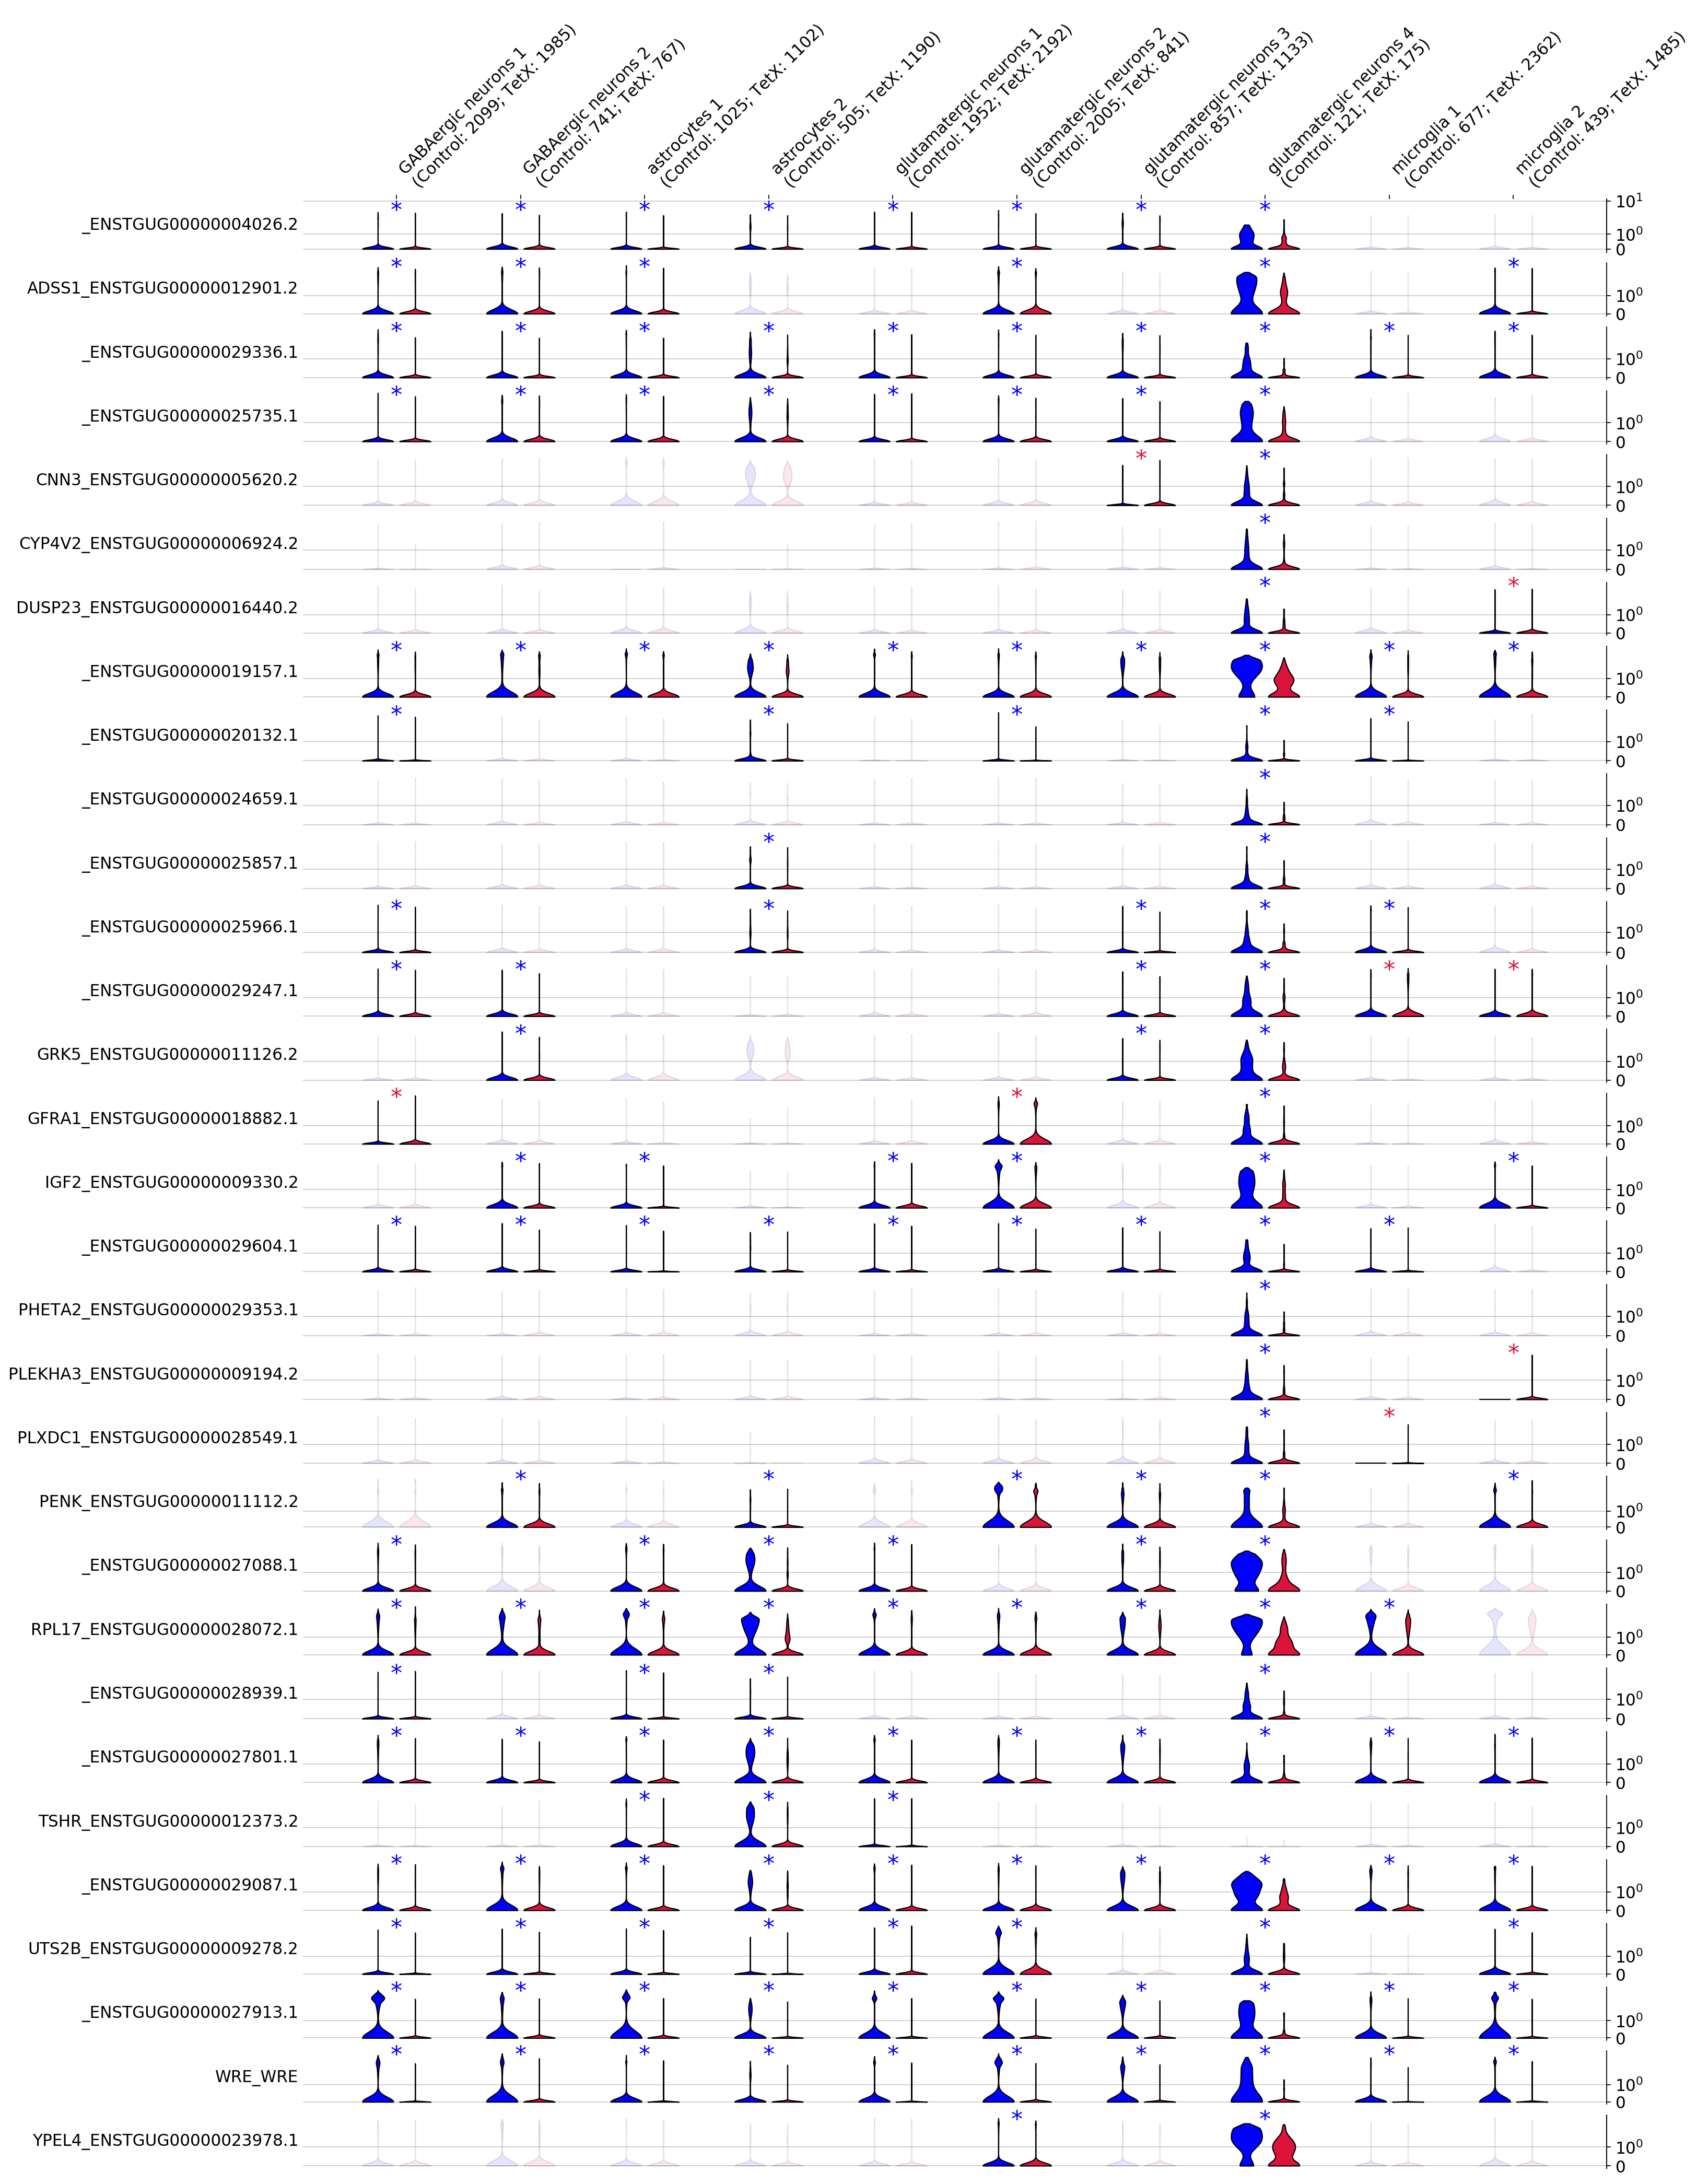

In [47]:
genes = df_DE_ctrl["gene_ID"].values
labels = df_DE_ctrl["gene_ID"].values
celltypes = clusters

ax = violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="DE_CTRL_individual-clusters_t-test",
    fold_change_min=1.5,
)

Plot genes that are higher in experiment:

Individual cluster analysis (obs column: celltype).


/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:80: RuntimeWarning: invalid value encountered in float_scalars
  fold_change = np.mean(x_ctrl[index]) / np.mean(cell_array)


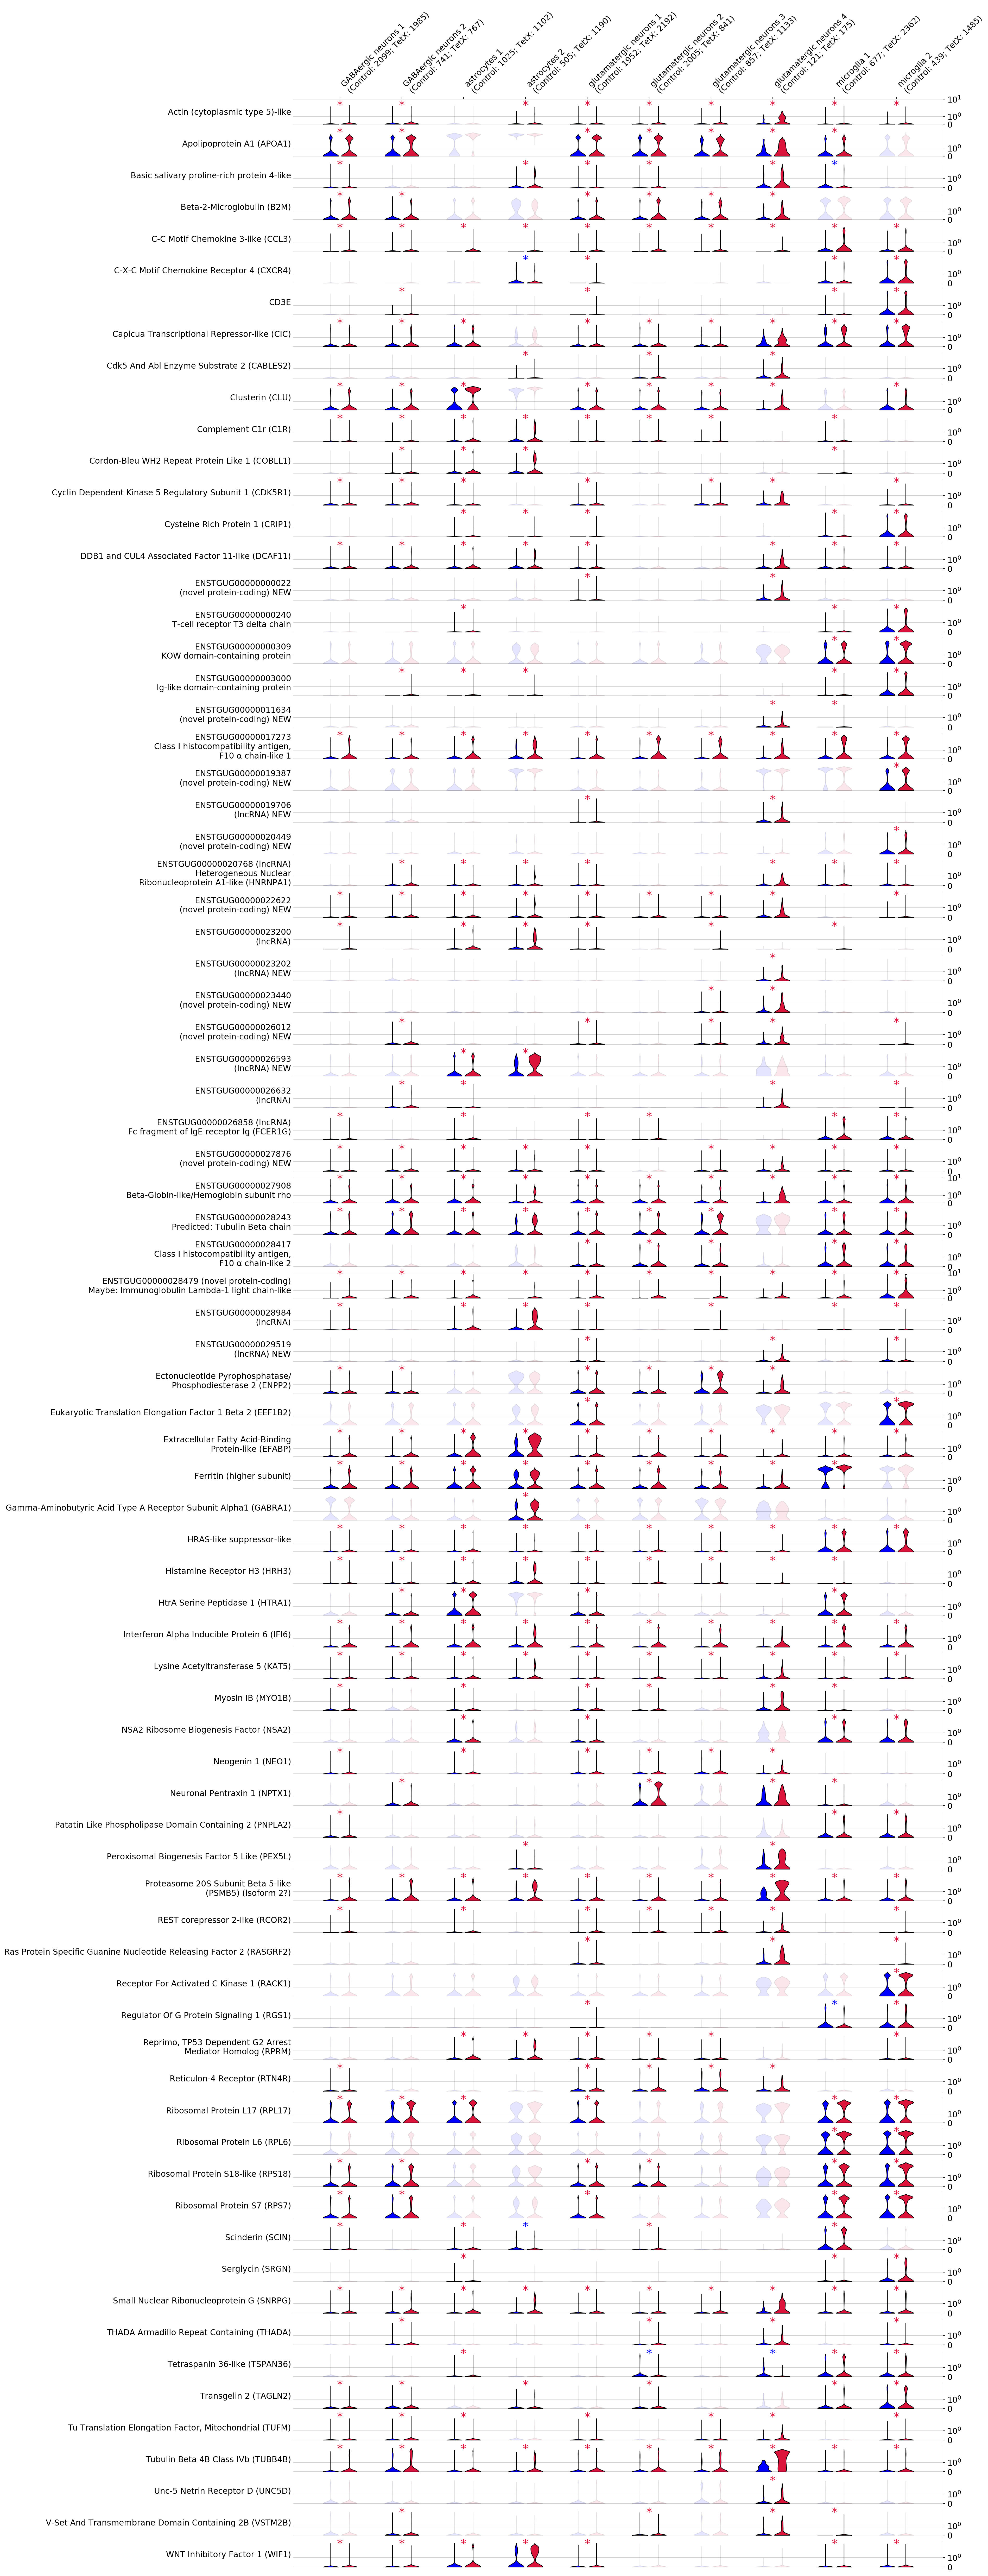

In [48]:
genes = df_DE_exp["gene_ID"].values
labels = df_DE_exp["gene_name"].values
celltypes = clusters

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="DE_EXP_individual-clusters_t-test",
    fold_change_min=1.5,
)

Plot only lncRNAs:

Individual cluster analysis (obs column: celltype).


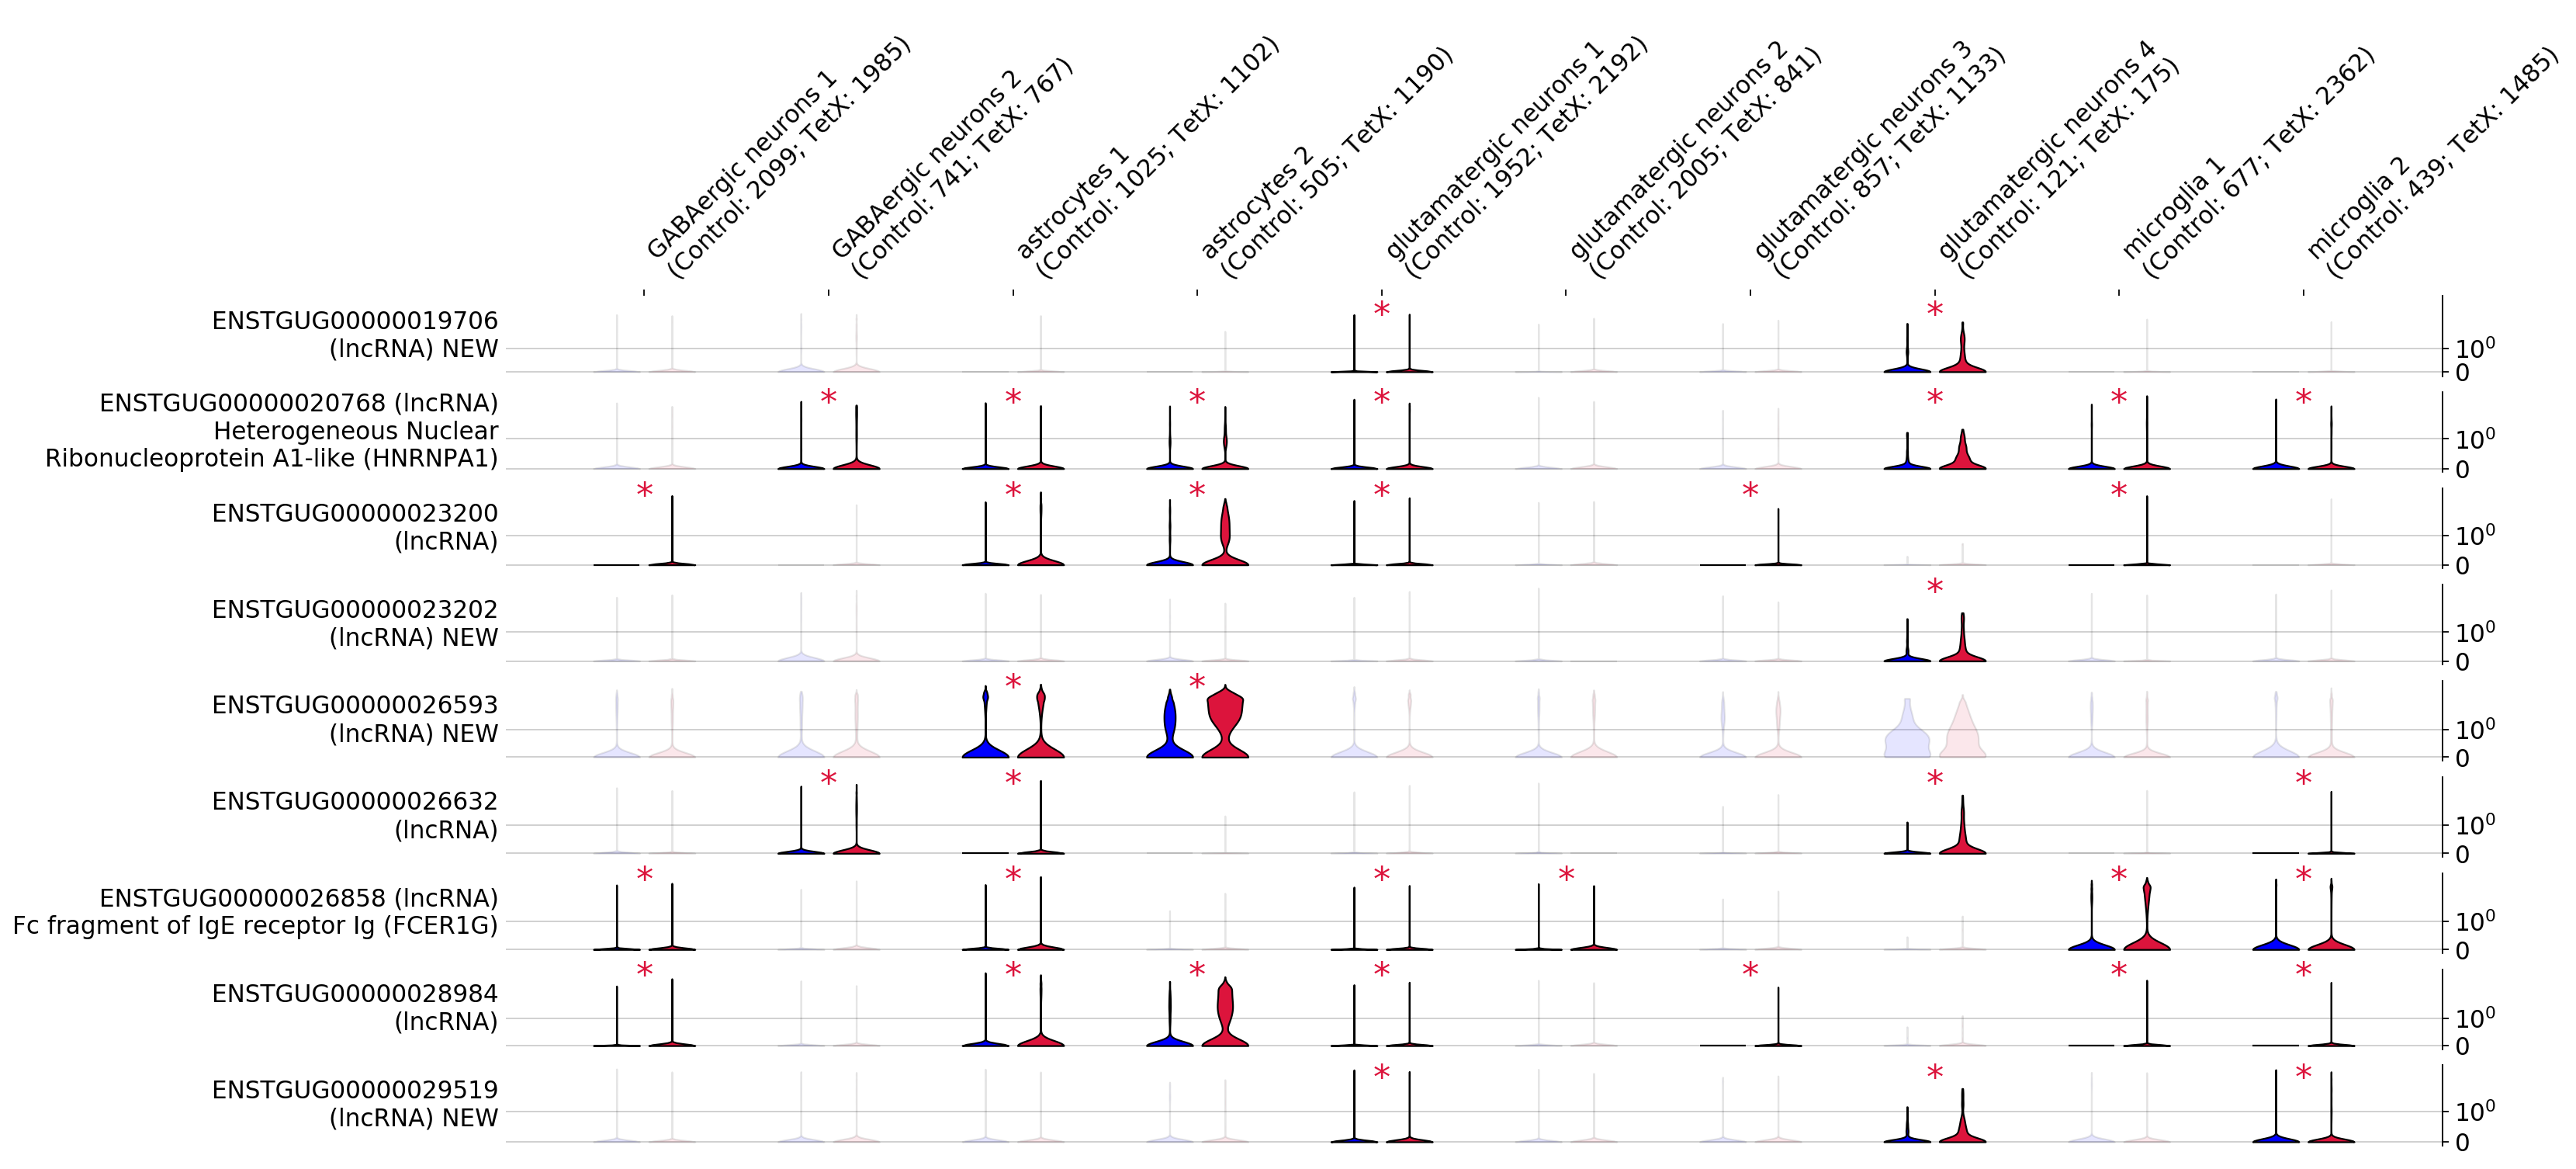

In [49]:
genes = df_DE_exp[df_DE_exp["gene_name"].str.contains("lncRNA")]["gene_ID"].values
labels = df_DE_exp[df_DE_exp["gene_name"].str.contains("lncRNA")]["gene_name"].values
celltypes = clusters

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="DE_EXP_lncRNAs_t-test",
    fold_change_min=1.5,
)

In [50]:
## DE genes if clusters with < 100 cells are also taken into account and only first 20 DE genes are kept:
# ctrl_gene_names = [
#     "ENSTGUG00000027913\n (novel protein-coding gene)",
#     "Proteasome Subunit Beta 5-like (PSMB5)",
#     "Tubulin Beta 7 chain (TUBB7)",
#     "Asparagine Synthetase Domain containing 1 (ASNSD1)",
#     "ENSTGUG00000019465\n (lncRNA)",
#     "ENSTGUG00000026317\n (lncRNA)",
#     "Ribosome Production Factor 2 Homolog (RPF2)",
#     "ENSTGUG00000028085\n (lncRNA)",
#     "ENSTGUG00000025142\n (novel protein-coding)",
#     "ENSTGUG00000025767\n (lncRNA)",
#     "Optic atrophy 3 (OPA3) protein homolog",
#     "Ribosomal Protein L17 (RPL17)",
#     "Thyroid Stimulating Hormone Receptor (TSHR)",
#     "ENSTGUG00000027801\n (novel protein-coding)",
#     "WRE",
#     "Insulin Like Growth Factor 2 (IGF2)",
#     "All-Trans Retinoic Acid Induced Differentiation factor (ATRAID)",
#     "Actin, cytoplasmic type 5",
#     "G Protein Subunit Gamma 4 (GNG4)",
#     "Solute Carrier Family 6 Member 19 (SLC6A19)",
#     "Polypeptide N-Acetylgalactosaminyltransferase 4 (GALNT4)",
#     "Toll Interacting Protein (TOLLIP)",
#     "YY1 Associated Factor 2 (YAF2)",
#     "Dynein Cytoplasmic 1 Intermediate Chain 2 (DYNC1I2)",
#     "G Protein Subunit Gamma 7 (GNG7)",
#     "Ubiquitin C-Terminal Hydrolase L1 (UCHL1)",
#     "Frataxin (FXN)",
#     "NSE2 (MMS21) Homolog (NSMCE2)",
#     "RNA Polymerase II CTD Phosphatase (SSU72 Homolog)"
# ]
    
# df_DE_ctrl = pd.DataFrame()
# df_DE_ctrl["gene_ID"] = DE_ctrl
# df_DE_ctrl["gene_name"] = ctrl_gene_names
# # # Sort gene alphabetically 
# # df_DE_ctrl = df_DE_ctrl.sort_values("gene_name")
# df_DE_ctrl